In [1]:
from sympy import *
import numpy as np
import pandas as pd
from copy import copy,deepcopy
import random
import matplotlib.pyplot as plt

In [47]:
def plotCA(data,size=(20,10)):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(data,plt.cm.Greys)
    plt.ylabel("steps",fontsize="large")
    for i in range(len(data)):
        for j in range(len(data[i])):
            c = "w"
            if data[i][j] <= 2:
                c = "black"
            text = ax.text(j, i, data[i][j],
                           ha="center", va="center", color=c,fontsize="large")
    plt.show()

def cpAp(e,lst):
    a = np.append(e,lst)
    return a

def aptitud(pos,neg,notapt):
    pos_values = {}
    neg_values = {}
    onlykeys = {x[0] for x in notapt}
    for i in range(len(pos)):
        for j in range(len(pos[i])):
            if str(j) not in pos_values:
                pos_values[str(j)+",1"] = 0
                pos_values[str(j)+",0"] = 0
            if pos[i][j] == 1:
                key = str(j)+",1"
            else:
                key = "{},0".format(j)
            if key not in onlykeys:
                pos_values[key] += 1
    for i in range(len(neg)):
        for j in range(len(neg[i])):
            if str(j) not in neg_values:
                neg_values[str(j)+",1"] = 0
                neg_values[str(j)+",0"] = 0
            if neg[i][j] == 1:
                key = str(j)+",1"
            else:
                key = "{},0".format(j)
            if key not in onlykeys:
                neg_values[key] += 1
    res = []
    for key in pos_values:
        if neg_values[key] == 0 and pos_values[key] != 0:
            res.append([key,1000])
        elif neg_values[key] != 0:
            res.append([key,pos_values[key]/neg_values[key]])
    res.sort(key=lambda x: x[1],reverse=True)
    return res

def removeBest(pos,key):
    filtered = []
    key = key.split(",")
    index = int(key[0])
    value = int(key[1])
    for i in range(len(pos)):
        if pos[i][index] != value:
            filtered.append(pos[i])
    return filtered

def removeNeg(neg,t):
    newneg = []
    for i in range(len(neg)):
        add = False
        for j in range(len(t)):
            key = t[j]
            key = key.split(",")
            index = int(key[0])
            value = int(key[1])
            if neg[i][index] == value:
                add = True
                break
        if add:
            newneg.append(neg[i])
    return newneg

def ocat(data,m):
    neg = deepcopy(data["neg"])
    C = []
    while len(neg) > 0:
        t = []
        pos = deepcopy(data["pos"])
        notapt = []
        while len(pos) > 0:
            apt = aptitud(pos,neg,notapt)
            if m >= len(apt):
                notapt = []
            else:
                notapt = apt[m:]
                apt = apt[:m]
            best = apt[0]
            t.append(best[0])
            pos = removeBest(pos,best[0])
        C.append(t)
        neg = removeNeg(neg,t)
    return C

<img src="images/squaringCA.png"/>

Para cada uno de los atributos encontrar su funcion de trancision local
## cargamos el dataset del automata celular que calcula 2^2

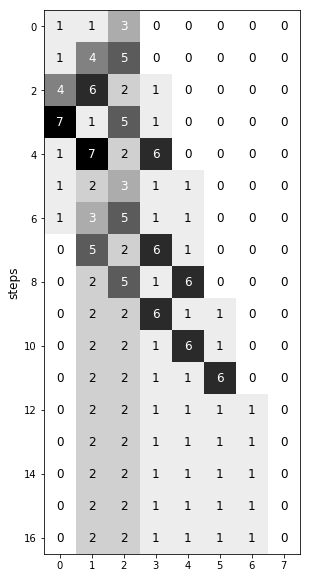

In [71]:
dataframe = pd.read_csv("data/2_square.csv")
plotCA(dataframe.values)

### Eliminamos las filas redundantes

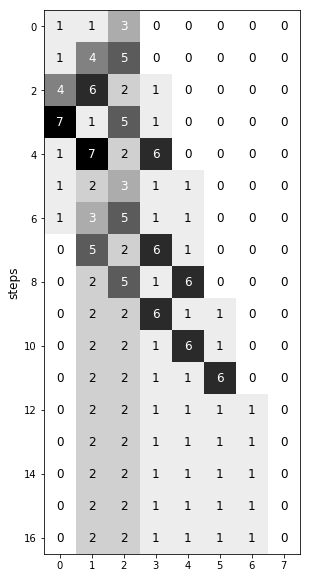

In [72]:
#dataframe = dataframe.iloc[np.tile([True,False], 7),:]
plotCA(dataframe.values,(15,10))

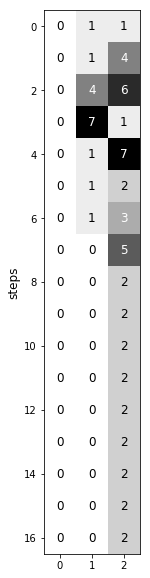

In [104]:
#creamos un problema de aprendizaje para cada celda
attr_state = {}
for i,row in dataframe.iterrows():
    for j in range(len(dataframe.columns)):
        if j not in attr_state:
            attr_state[j] = []
        x1 = 0
        x2 = row[j]
        x3 = 0
        if j != 0:
            x1 = row[j-1]
        if j != len(dataframe.columns)-1:
            x3 = row[j+1]
        attr_state[j].append([x1,x2,x3])
plotCA(attr_state[0])

In [74]:
#encontramos los valores observados de cada atributo en los subproblemas de aprendizaje
domain = {}
for key in attr_state:
    for row in attr_state[key]:
        for j,col in enumerate(row):
            if key not in domain:
                domain[key] = {}
            if j not in domain[key]:
                domain[key][j] = []
            if col not in domain[key][j]:
                domain[key][j].append(col)
for k in domain:
    for j in domain[k]:
        domain[k][j].sort()
domain

{0: {0: [0], 1: [0, 1, 4, 7], 2: [1, 2, 3, 4, 5, 6, 7]},
 1: {0: [0, 1, 4, 7], 1: [1, 2, 3, 4, 5, 6, 7], 2: [2, 3, 5]},
 2: {0: [1, 2, 3, 4, 5, 6, 7], 1: [2, 3, 5], 2: [0, 1, 6]},
 3: {0: [2, 3, 5], 1: [0, 1, 6], 2: [0, 1, 6]},
 4: {0: [0, 1, 6], 1: [0, 1, 6], 2: [0, 1, 6]},
 5: {0: [0, 1, 6], 1: [0, 1, 6], 2: [0, 1]},
 6: {0: [0, 1, 6], 1: [0, 1], 2: [0]},
 7: {0: [0, 1], 1: [0], 2: [0]}}

In [75]:
#binarizamos los subproblemas de aprendizaje
binarized = {}
segments = {}
for key in attr_state:
    for row in attr_state[key]:
        temp = []
        if key not in binarized:
            binarized[key] = []
        if key not in segments:
            segments[key] = {}
        for j,col in enumerate(row):
            if len(domain[key][j]) > 1:
                if j not in segments[key]:
                    segments[key][j] = []
                if len(temp) not in segments[key][j]:
                    segments[key][j].append(len(temp))
                for k,val in enumerate(domain[key][j]):
                    if col >= val:
                        temp.append(1)
                    else:
                        temp.append(0)
                if len(temp)-1 not in segments[key][j]:
                    segments[key][j].append(len(temp)-1)
            else:
                temp.append(0)
        binarized[key].append(temp)
binarized[0]

[[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
 [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]]

In [76]:
# obtenemos los ejemplos positivos y negativos para el atributo x[1] de los subproblemas
pos_neg = {}
for key in attr_state:
    if key not in pos_neg:
        pos_neg[key] = {}
    for j,col in enumerate(domain[key][1]):
        if col not in pos_neg[key]:
            pos_neg[key][col] = {"pos":[],"neg":[]}
        for i,row in enumerate(attr_state[key]):
            if row[1] == col:
                if i > 0:
                    pos_neg[key][col]["pos"].append(binarized[key][i-1])
            else:
                if i > 0:
                    pos_neg[key][col]["neg"].append(binarized[key][i-1])
pos_neg[0]

{0: {'pos': [[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]],
  'neg': [[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
   [0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
   [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
   [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
   [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
   [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]]},
 1: {'pos': [[0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
   [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
   [0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
   [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0]],
  'neg': [[0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0],
   [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
   [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
   [0, 1, 0, 0, 0, 

In [77]:
rules = {}
for key in pos_neg:
    if key not in rules:
        rules[key] = {}
    for cls in pos_neg[key]:
        if len(pos_neg[key][cls]["pos"]) > 0 and len(pos_neg[key][cls]["neg"]) > 0:
            if cls not in rules[key]:
                rules[key][cls] = []
            rules[key][cls] = ocat(pos_neg[key][cls],5)
rules

{0: {0: [['2,0', '7,1'], ['2,0', '8,0']],
  1: [['2,1'], ['7,0', '8,1'], ['3,0', '4,1'], ['7,0', '9,1']],
  4: [['2,1'], ['8,1'], ['9,0']],
  7: [['2,1'], ['3,1'], ['4,0']]},
 1: {1: [['1,1'], ['2,1'], ['3,0']],
  2: [['1,0', '7,1'], ['1,0', '2,0'], ['1,0', '8,1']],
  3: [['1,1'], ['6,0'], ['2,0'], ['5,1']],
  4: [['1,1'], ['5,0'], ['2,0']],
  5: [['1,1'], ['6,1'], ['7,0']],
  6: [['1,1'], ['7,1'], ['8,0']],
  7: [['1,1'], ['2,1'], ['3,1']]},
 2: {2: [['2,0', '3,0', '4,0'], ['8,0', '9,1']],
  3: [['2,1'], ['5,1'], ['6,1']],
  5: [['2,1', '8,1'],
   ['2,1', '9,0'],
   ['3,1', '2,0'],
   ['5,0', '6,0'],
   ['4,1', '2,0']]},
 3: {0: [['1,1'], ['2,0'], ['4,0']],
  1: [['1,0', '2,0', '4,0'], ['1,0', '4,1', '2,1']],
  6: [['1,1'], ['2,1'], ['4,1']]},
 4: {0: [['4,0'], ['2,0']],
  1: [['2,0', '4,0'], ['4,1', '2,1']],
  6: [['2,1'], ['4,1']]},
 5: {0: [['4,0'], ['2,0']],
  1: [['2,0', '4,0'], ['4,1', '2,1']],
  6: [['2,1'], ['4,1']]},
 6: {0: [['4,0'], ['2,0']], 1: [['4,1', '2,1']]},
 7: {}}

In [78]:
#Obtenemos las clausulas
selectors = {}
for key in rules:
    if key not in selectors:
        selectors[key] = {}
    for attr in rules[key]:
        if attr not in selectors[key]:
            selectors[key][attr] = ""
        ands = []
        for row in rules[key][attr]:
            ors = []
            for col in row:
                temp = col.split(",")
                index = int(temp[0])
                val = int(temp[1])
                selector = ""
                for ksect in segments[key]:
                    if index >= segments[key][ksect][0] and index <= segments[key][ksect][1]:
                        if val == 0:
                            selector += "A{} < {}".format(ksect,domain[key][ksect][index-segments[key][ksect][0]])
                        else:
                            selector += "A{} >= {}".format(ksect,domain[key][ksect][index-segments[key][ksect][0]])
                        break
                if selector != "":
                    ors.append(selector)
                else:
                    if val == 0:
                        ors.append("!A{}".format(index))
                    else:
                        ors.append("A{}".format(index))
            ands.append(" or ".join(ors))
        selectors[key][attr] =  "("+(") and (".join(ands))+") --> " + str(attr) 
selectors

{0: {0: '(A1 < 1 or A2 >= 3) and (A1 < 1 or A2 < 4) --> 0',
  1: '(A1 >= 1) and (A2 < 3 or A2 >= 4) and (A1 < 4 or A1 >= 7) and (A2 < 3 or A2 >= 5) --> 1',
  4: '(A1 >= 1) and (A2 >= 4) and (A2 < 5) --> 4',
  7: '(A1 >= 1) and (A1 >= 4) and (A1 < 7) --> 7'},
 1: {1: '(A0 >= 1) and (A0 >= 4) and (A0 < 7) --> 1',
  2: '(A0 < 1 or A1 >= 4) and (A0 < 1 or A0 < 4) and (A0 < 1 or A1 >= 5) --> 2',
  3: '(A0 >= 1) and (A1 < 3) and (A0 < 4) and (A1 >= 2) --> 3',
  4: '(A0 >= 1) and (A1 < 2) and (A0 < 4) --> 4',
  5: '(A0 >= 1) and (A1 >= 3) and (A1 < 4) --> 5',
  6: '(A0 >= 1) and (A1 >= 4) and (A1 < 5) --> 6',
  7: '(A0 >= 1) and (A0 >= 4) and (A0 >= 7) --> 7'},
 2: {2: '(A0 < 3 or A0 < 4 or A0 < 5) and (A1 < 3 or A1 >= 5) --> 2',
  3: '(A0 >= 3) and (A0 >= 6) and (A0 >= 7) --> 3',
  5: '(A0 >= 3 or A1 >= 3) and (A0 >= 3 or A1 < 5) and (A0 >= 4 or A0 < 3) and (A0 < 6 or A0 < 7) and (A0 >= 5 or A0 < 3) --> 5'},
 3: {0: '(A0 >= 3) and (A0 < 5) and (A1 < 1) --> 0',
  1: '(A0 < 3 or A0 < 5 or A1 <

In [79]:
#Obtenemos las clausulas
boolFuncs = {}
for key in rules:
    if key not in boolFuncs:
        boolFuncs[key] = {}
    for attr in rules[key]:
        if attr not in boolFuncs[key]:
            boolFuncs[key][attr] = ""
        ands = []
        for row in rules[key][attr]:
            ors = []
            for col in row:
                temp = col.split(",")
                index = int(temp[0])
                val = int(temp[1])
                selector = ""
                for ksect in segments[key]:
                    if index >= segments[key][ksect][0] and index <= segments[key][ksect][1]:
                        if val == 0:
                            selector += "A{} < {}".format(ksect,domain[key][ksect][index-segments[key][ksect][0]])
                        else:
                            selector += "A{} >= {}".format(ksect,domain[key][ksect][index-segments[key][ksect][0]])
                        break
                if selector != "":
                    ors.append(selector)
                else:
                    if val == 0:
                        ors.append("!A{}".format(index))
                    else:
                        ors.append("A{}".format(index))
            ands.append(" or ".join(ors))
        boolFuncs[key][attr] =  "(("+(") and (".join(ands))+"))"
boolFuncs

{0: {0: '((A1 < 1 or A2 >= 3) and (A1 < 1 or A2 < 4))',
  1: '((A1 >= 1) and (A2 < 3 or A2 >= 4) and (A1 < 4 or A1 >= 7) and (A2 < 3 or A2 >= 5))',
  4: '((A1 >= 1) and (A2 >= 4) and (A2 < 5))',
  7: '((A1 >= 1) and (A1 >= 4) and (A1 < 7))'},
 1: {1: '((A0 >= 1) and (A0 >= 4) and (A0 < 7))',
  2: '((A0 < 1 or A1 >= 4) and (A0 < 1 or A0 < 4) and (A0 < 1 or A1 >= 5))',
  3: '((A0 >= 1) and (A1 < 3) and (A0 < 4) and (A1 >= 2))',
  4: '((A0 >= 1) and (A1 < 2) and (A0 < 4))',
  5: '((A0 >= 1) and (A1 >= 3) and (A1 < 4))',
  6: '((A0 >= 1) and (A1 >= 4) and (A1 < 5))',
  7: '((A0 >= 1) and (A0 >= 4) and (A0 >= 7))'},
 2: {2: '((A0 < 3 or A0 < 4 or A0 < 5) and (A1 < 3 or A1 >= 5))',
  3: '((A0 >= 3) and (A0 >= 6) and (A0 >= 7))',
  5: '((A0 >= 3 or A1 >= 3) and (A0 >= 3 or A1 < 5) and (A0 >= 4 or A0 < 3) and (A0 < 6 or A0 < 7) and (A0 >= 5 or A0 < 3))'},
 3: {0: '((A0 >= 3) and (A0 < 5) and (A1 < 1))',
  1: '((A0 < 3 or A0 < 5 or A1 < 1) and (A0 < 3 or A1 >= 1 or A0 >= 5))',
  6: '((A0 >= 3) 

In [80]:
def testRulesOneDimension(initConfig,iterations,rules):
    appliedRules = {}
    evolution = [] 
    curr = copy(initConfig)
    evolution.append(curr)
    for step in range(iterations):
        if step not in appliedRules:
            appliedRules[step] = {}
        newCurr = copy(curr)
        for i,cell in enumerate(curr):
            if i not in appliedRules[step]:
                appliedRules[step][i] = []
            rule = rules[i]
            for j,op in enumerate(rule):
                A0 = 0
                A1 = cell
                A2 = 0
                if i != 0:
                    A0 = curr[i-1]
                if i != len(curr)-1:
                    A2 = curr[i+1]
                if eval(rule[op]):
                    newCurr[i] = op
                    appliedRules[step][i].append(op)
        curr = newCurr
        evolution.append(curr)
    return {"history":evolution,"appliedRules":appliedRules}                      

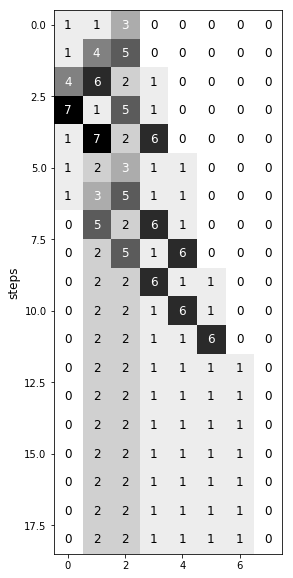

In [81]:
res = testRulesOneDimension([1,1,3,0,0,0,0,0],18,boolFuncs)
plotCA(res["history"])

In [82]:
res["history"]

[[1, 1, 3, 0, 0, 0, 0, 0],
 [1, 4, 5, 0, 0, 0, 0, 0],
 [4, 6, 2, 1, 0, 0, 0, 0],
 [7, 1, 5, 1, 0, 0, 0, 0],
 [1, 7, 2, 6, 0, 0, 0, 0],
 [1, 2, 3, 1, 1, 0, 0, 0],
 [1, 3, 5, 1, 1, 0, 0, 0],
 [0, 5, 2, 6, 1, 0, 0, 0],
 [0, 2, 5, 1, 6, 0, 0, 0],
 [0, 2, 2, 6, 1, 1, 0, 0],
 [0, 2, 2, 1, 6, 1, 0, 0],
 [0, 2, 2, 1, 1, 6, 0, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0],
 [0, 2, 2, 1, 1, 1, 1, 0]]

In [83]:
boolRules2 = {}
for c in boolFuncs:
    for r in boolFuncs[c]:
        if r not in boolRules2:
            boolRules2[r] = []
        boolRules2[r].append(boolFuncs[c][r])
boolRules3 = {}
for r in boolRules2:
    if r not in boolRules3:
        boolRules3[r] = ""
    boolRules3[r] = " and ".join(boolRules2[r])
boolRules3

{0: '((A1 < 1 or A2 >= 3) and (A1 < 1 or A2 < 4)) and ((A0 >= 3) and (A0 < 5) and (A1 < 1)) and ((A1 < 1) and (A0 < 6)) and ((A1 < 1) and (A0 < 6)) and ((A1 < 1) and (A0 < 6))',
 1: '((A1 >= 1) and (A2 < 3 or A2 >= 4) and (A1 < 4 or A1 >= 7) and (A2 < 3 or A2 >= 5)) and ((A0 >= 1) and (A0 >= 4) and (A0 < 7)) and ((A0 < 3 or A0 < 5 or A1 < 1) and (A0 < 3 or A1 >= 1 or A0 >= 5)) and ((A0 < 6 or A1 < 1) and (A1 >= 1 or A0 >= 6)) and ((A0 < 6 or A1 < 1) and (A1 >= 1 or A0 >= 6)) and ((A1 >= 1 or A0 >= 6))',
 4: '((A1 >= 1) and (A2 >= 4) and (A2 < 5)) and ((A0 >= 1) and (A1 < 2) and (A0 < 4))',
 7: '((A1 >= 1) and (A1 >= 4) and (A1 < 7)) and ((A0 >= 1) and (A0 >= 4) and (A0 >= 7))',
 2: '((A0 < 1 or A1 >= 4) and (A0 < 1 or A0 < 4) and (A0 < 1 or A1 >= 5)) and ((A0 < 3 or A0 < 4 or A0 < 5) and (A1 < 3 or A1 >= 5))',
 3: '((A0 >= 1) and (A1 < 3) and (A0 < 4) and (A1 >= 2)) and ((A0 >= 3) and (A0 >= 6) and (A0 >= 7))',
 5: '((A0 >= 1) and (A1 >= 3) and (A1 < 4)) and ((A0 >= 3 or A1 >= 3) and (

In [84]:
def testRulesOneDimension2(initConfig,iterations,rules):
    appliedRules = {}
    evolution = [] 
    curr = copy(initConfig)
    evolution.append(curr)
    for step in range(iterations):
        if step not in appliedRules:
            appliedRules[step] = {}
        newCurr = copy(curr)
        for i,cell in enumerate(curr):
            if i not in appliedRules[step]:
                appliedRules[step][i] = []
            rule = rules
            for j,op in enumerate(rule):
                A0 = 0
                A1 = cell
                A2 = 0
                if i != 0:
                    A0 = curr[i-1]
                if i != len(curr)-1:
                    A2 = curr[i+1]
                if eval(rule[op]):
                    newCurr[i] = op
                    appliedRules[step][i].append(op)
        curr = newCurr
        evolution.append(curr)
    return {"history":evolution,"appliedRules":appliedRules}                      

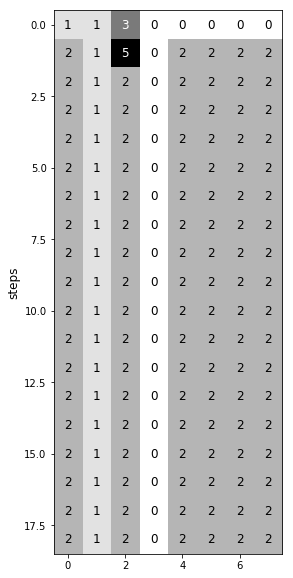

In [85]:
res = testRulesOneDimension2([1,1,3,0,0,0,0,0],18,boolRules3)
plotCA(res["history"])

In [91]:
literals = {}
literalsInv = {}
count = 0
for key in boolFuncs:
    for key2 in boolFuncs[key]:
        sel = boolFuncs[key][key2].replace("(","").replace(")","").replace("or",",").replace("and",",").replace(" ","").split(",")
        for el in sel:
            if el not in literals:
                literals[el] = "X{}".format(count)
                literalsInv["X{}".format(count)] = el
                count += 1
literals    

{'A1<1': 'X0',
 'A2>=3': 'X1',
 'A2<4': 'X2',
 'A1>=1': 'X3',
 'A2<3': 'X4',
 'A2>=4': 'X5',
 'A1<4': 'X6',
 'A1>=7': 'X7',
 'A2>=5': 'X8',
 'A2<5': 'X9',
 'A1>=4': 'X10',
 'A1<7': 'X11',
 'A0>=1': 'X12',
 'A0>=4': 'X13',
 'A0<7': 'X14',
 'A0<1': 'X15',
 'A0<4': 'X16',
 'A1>=5': 'X17',
 'A1<3': 'X18',
 'A1>=2': 'X19',
 'A1<2': 'X20',
 'A1>=3': 'X21',
 'A1<5': 'X22',
 'A0>=7': 'X23',
 'A0<3': 'X24',
 'A0<5': 'X25',
 'A0>=3': 'X26',
 'A0>=6': 'X27',
 'A0<6': 'X28',
 'A0>=5': 'X29'}

In [93]:
clausulesWLiterals = {}
for key in boolFuncs:
    for key2 in boolFuncs[key]:
        clsstr = boolFuncs[key][key2].replace(" ","").replace("or"," or ").replace("and"," and ")
        count = 0
        for key3 in literals:
            if key3 in clsstr:
                clsstr = clsstr.replace(key3,literals[key3])
                count += 1
        if key not in clausulesWLiterals:
            clausulesWLiterals[key] = {}
        if key not in clausulesWLiterals[key]:
            clausulesWLiterals[key][key2] = []
        clausulesWLiterals[key][key2]=[clsstr,count]

clausulesWLiterals

{0: {0: ['((X0 or X1) and (X0 or X2))', 3],
  1: ['((X3) and (X4 or X5) and (X6 or X7) and (X4 or X8))', 6],
  4: ['((X3) and (X5) and (X9))', 3],
  7: ['((X3) and (X10) and (X11))', 3]},
 1: {1: ['((X12) and (X13) and (X14))', 3],
  2: ['((X15 or X10) and (X15 or X16) and (X15 or X17))', 4],
  3: ['((X12) and (X18) and (X16) and (X19))', 4],
  4: ['((X12) and (X20) and (X16))', 3],
  5: ['((X12) and (X21) and (X6))', 3],
  6: ['((X12) and (X10) and (X22))', 3],
  7: ['((X12) and (X13) and (X23))', 3]},
 2: {2: ['((X24 or X16 or X25) and (X18 or X17))', 5],
  3: ['((X26) and (X27) and (X23))', 3],
  5: ['((X26 or X21) and (X26 or X22) and (X13 or X24) and (X28 or X14) and (X29 or X24))',
   8]},
 3: {0: ['((X26) and (X25) and (X0))', 3],
  1: ['((X24 or X25 or X0) and (X24 or X3 or X29))', 5],
  6: ['((X26) and (X29) and (X3))', 3]},
 4: {0: ['((X0) and (X28))', 2],
  1: ['((X28 or X0) and (X3 or X27))', 4],
  6: ['((X27) and (X3))', 2]},
 5: {0: ['((X0) and (X28))', 2],
  1: ['((X28 o

In [100]:
simpExpr = {}
for key in clausulesWLiterals:
    for key2 in clausulesWLiterals[key]:
        strexpr = clausulesWLiterals[key][key2][0]
        print(key)
        strexpr = strexpr.replace("or","|").replace("and","&").replace("[","").replace("]","")
        strsimp = str(simplify_logic(strexpr,force=(clausulesWLiterals[key][key2][1] >= 8)))
        strsimp = strsimp.replace("|","or").replace("&","and")
        if key not in simpExpr:
            simpExpr[key] = {}
        if key2 not in simpExpr[key]:
            simpExpr[key][key2] = ""
        simpExpr[key][key2] = strsimp
simpExpr

0
0
0
0
1
1
1
1
1
1
1
2
2
2
3
3
3
4
4
4
5
5
5
6
6


{0: {0: 'X0 or (X1 and X2)',
  1: 'X3 and (X4 or X5) and (X4 or X8) and (X6 or X7)',
  4: 'X3 and X5 and X9',
  7: 'X10 and X11 and X3'},
 1: {1: 'X12 and X13 and X14',
  2: 'X15 or (X10 and X16 and X17)',
  3: 'X12 and X16 and X18 and X19',
  4: 'X12 and X16 and X20',
  5: 'X12 and X21 and X6',
  6: 'X10 and X12 and X22',
  7: 'X12 and X13 and X23'},
 2: {2: '(X16 and X17) or (X16 and X18) or (X17 and X24) or (X17 and X25) or (X18 and X24) or (X18 and X25)',
  3: 'X23 and X26 and X27',
  5: '(X13 or X24) and (X14 or X28) and (X21 or X26) and (X22 or X26) and (X24 or X29)'},
 3: {0: 'X0 and X25 and X26',
  1: 'X24 or (X0 and X29) or (X0 and X3) or (X25 and X29) or (X25 and X3)',
  6: 'X26 and X29 and X3'},
 4: {0: 'X0 and X28',
  1: '(X0 and X27) or (X0 and X3) or (X27 and X28) or (X28 and X3)',
  6: 'X27 and X3'},
 5: {0: 'X0 and X28',
  1: '(X0 and X27) or (X0 and X3) or (X27 and X28) or (X28 and X3)',
  6: 'X27 and X3'},
 6: {0: 'X0 and X28', 1: 'X27 or X3'}}

In [103]:
simpExpr2 = {}
for key in simpExpr:
    for key2 in simpExpr[key]:
        temp = simpExpr[key][key2].replace(")"," )") + " "
        for key3 in literalsInv:
            temp = temp.replace(key3+" ",literalsInv[key3]+" ")
        if key not in simpExpr2:
            simpExpr2[key] = {}
        if key2 not in simpExpr2[key]:
            simpExpr2[key][key2] = ""
        simpExpr2[key][key2] = temp
simpExpr2

{0: {0: 'A1<1 or (A2>=3 and A2<4 ) ',
  1: 'A1>=1 and (A2<3 or A2>=4 ) and (A2<3 or A2>=5 ) and (A1<4 or A1>=7 ) ',
  4: 'A1>=1 and A2>=4 and A2<5 ',
  7: 'A1>=4 and A1<7 and A1>=1 '},
 1: {1: 'A0>=1 and A0>=4 and A0<7 ',
  2: 'A0<1 or (A1>=4 and A0<4 and A1>=5 ) ',
  3: 'A0>=1 and A0<4 and A1<3 and A1>=2 ',
  4: 'A0>=1 and A0<4 and A1<2 ',
  5: 'A0>=1 and A1>=3 and A1<4 ',
  6: 'A1>=4 and A0>=1 and A1<5 ',
  7: 'A0>=1 and A0>=4 and A0>=7 '},
 2: {2: '(A0<4 and A1>=5 ) or (A0<4 and A1<3 ) or (A1>=5 and A0<3 ) or (A1>=5 and A0<5 ) or (A1<3 and A0<3 ) or (A1<3 and A0<5 ) ',
  3: 'A0>=7 and A0>=3 and A0>=6 ',
  5: '(A0>=4 or A0<3 ) and (A0<7 or A0<6 ) and (A1>=3 or A0>=3 ) and (A1<5 or A0>=3 ) and (A0<3 or A0>=5 ) '},
 3: {0: 'A1<1 and A0<5 and A0>=3 ',
  1: 'A0<3 or (A1<1 and A0>=5 ) or (A1<1 and A1>=1 ) or (A0<5 and A0>=5 ) or (A0<5 and A1>=1 ) ',
  6: 'A0>=3 and A0>=5 and A1>=1 '},
 4: {0: 'A1<1 and A0<6 ',
  1: '(A1<1 and A0>=6 ) or (A1<1 and A1>=1 ) or (A0>=6 and A0<6 ) or (A0<6 and 

In [ ]:
res = testRulesOneDimension2([1,1,3,0,0,0,0,0],18,simpExpr2)
plotCA(res["history"])